/home/robert/anaconda3/envs/compneurosci/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


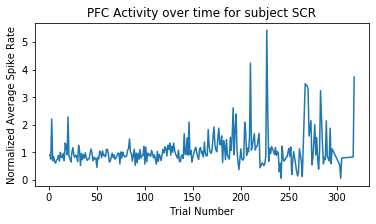

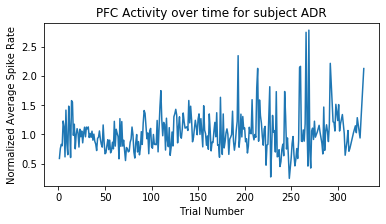

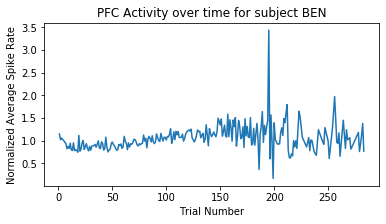

In [4]:
import src.io as projectio
import matplotlib.pyplot as plt

# Constants for different subjects and file locations
subjects = ['SCR', 'ELV', 'ADR', 'BEN']
base_dir = 'data/pfc3/data/'
summary_db = 'data/pfc3/SummaryDatabase-Pre_FeatureSets.csv'

# List of all files for given summary db
# IMPORTANT: See data/README.md for details on splitting SummaryDatabase.xlsx
files = projectio.files_from_csv(summary_db)

# Sort neuron files by subject
files_by_subject = {}
for subject in subjects:
    s_list = []
    for file in files:
        if file.startswith(subject):
            s_list.append(file)
    files_by_subject[subject] = s_list

# Class for simplifying data handling per neuron
class NeuronData:
    def __init__(self, trial_dict, average):
        """
        trial_dict (dictionary): mapping of trial numbers to spike rates
        average (float): Average spike rate across all trials
        """
        self.trial_dict = trial_dict
        self.average = average

    def normalize(self):
        """
        Updates dictionary to normalized spike rate based on overall average
        """
        for trial in self.trial_dict:
            self.trial_dict[trial] = self.trial_dict[trial]/self.average
    
# Different subjects had different trial format, so simpler to create a single function
def subject_process(subject, trial_index, start_index, end_index, spikes_index):
    """
    subject (str): Subject name
    trial_index (int): Index in trial data for trial numbers
    start_index (int): Index in trial data for starting timestamp
    end_index (int): Index in trial data for ending timestamp
    spikes_index (int): Index in trial data for spike timestamps
    """
    file_list = files_by_subject[subject]

    # Get average firing rates for each trial in all neurons
    neuron_dict = {}
    for file in file_list:
        # Neuron number is the last portion of each filename
        neuron = int(file.split('_')[-1][:-4])
        
        # Handle neurons with recordings across multiple files
        if neuron in neuron_dict:
            trial_dict = neuron_dict[neuron].trial_dict
        else:
            trial_dict = {}
        
        # Process individual trials
        trials = projectio.file_to_trials(base_dir + file)
        for trial in trials:
            trial_num = trial[trial_index][0][0]
            trial_start = trial[start_index][0][0]
            trial_end = trial[end_index][0][0]
            spike_ct = 0
            # case where no spikes recorded has only one layer
            if len(trial[spikes_index]) != 0:
                for spike in trial[spikes_index][0]:
                    if spike > trial_start and spike < trial_end:
                        spike_ct += 1
            spike_rate = float(spike_ct)/(trial_end-trial_start)
            trial_dict[trial_num] = spike_rate
        #Get average spike rate over all trials
        total_rates = 0
        for trial in trial_dict:
            total_rates += trial_dict[trial]
        average_rate = total_rates/float(len(trial_dict))

        # Store data in dictionary of all neurons for subject
        neuron_dict[neuron] = NeuronData(trial_dict, average_rate)

    # Get total number of trials by finding max trial number across neurons
    num_trials = 0
    for neuron in neuron_dict:
        # Normalize spike data on per-neuron basis
        neuron_dict[neuron].normalize()
        num_trials = max(num_trials, max(neuron_dict[neuron].trial_dict.keys()))

    # Turn neuron data into a plotable format
    trial_list = []
    rate_list = []
    for i in range(1, num_trials + 1):
        # Average all neurons used for each trial
        num_neurons = 0
        total_rate = 0
        for neuron in neuron_dict:
            if i in neuron_dict[neuron].trial_dict:
                num_neurons += 1
                total_rate += neuron_dict[neuron].trial_dict[i]
        # Some trials have no recorded activity, so only track those with data
        if num_neurons > 0:
            trial_list.append(i)
            rate_list.append(total_rate/float(num_neurons))

    # Plot results
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
    axes.plot(trial_list, rate_list)
    axes.set_xlabel('Trial Number')
    axes.set_ylabel('Normalized Average Spike Rate')
    axes.set_title('PFC Activity over time for subject ' + subject)

subject_process(subject='SCR', trial_index=3, start_index=0, end_index=2, spikes_index=4)
subject_process(subject='ADR', trial_index=2, start_index=0, end_index=10, spikes_index=3)
subject_process(subject='BEN', trial_index=2, start_index=0, end_index=10, spikes_index=3)